In [17]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsmoothie.smoother import *
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.simplefilter("ignore")

## data

In [49]:
df = pd.read_csv(
    "data/financial_data_2000_2018_cleaned.csv.zip", 
    index_col = 0
)
df["timestamp"] = df.timestamp.apply(datetime.fromtimestamp)
df = df.loc[df.timestamp.dt.year > 2014].copy()
df.sort_values(["stock", "timestamp"], inplace = True)

print(df.shape)
df.head()

(35139, 7)


,stock,timestamp,open,high,low,adj_close,volume
9960,AAPL,2015-01-02 07:00:00,104.25,104.29,104.29,102.32,53204626
9959,AAPL,2015-01-05 07:00:00,101.35,101.68,101.68,99.44,64285491
9958,AAPL,2015-01-06 07:00:00,99.71,100.54,100.54,99.45,65797116
9957,AAPL,2015-01-07 07:00:00,100.33,101.26,101.26,100.84,40105934
9956,AAPL,2015-01-08 07:00:00,102.23,104.96,104.96,104.72,59364547


### Close Prices

In [51]:
df_close = df.set_index(["stock", "timestamp"])["adj_close"].unstack()
df_close = df_close.loc[~df_close.isna().any(axis = 1)].copy()
df_close.columns = range(len(df_close.columns))

print(df_close.shape)
df_close.head()

(39, 901)


,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,102.32,99.44,99.45,100.84,104.72,104.83,102.24,103.15,102.76,99.97,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,72.34,71.98,70.53,71.11,72.92,71.84,71.12,70.59,69.99,70.29,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,59.53,58.66,57.50,57.38,58.80,58.27,57.29,57.34,56.41,55.71,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AKRX,36.07,37.12,36.42,38.16,40.28,40.72,40.51,41.28,41.74,40.46,...,16.85,17.31,17.47,17.27,16.98,17.49,17.60,18.23,18.31,18.52
AMAT,23.59,22.83,21.97,22.18,22.88,22.91,22.36,22.05,21.75,22.04,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41


### Smooth Price

In [53]:
window_shape = 20
smoother = WindowWrapper(
    LowessSmoother(smooth_fraction = 0.6, iterations = 1), 
    window_shape = window_shape,
)
smoother.smooth(df_close.loc["AMZN"])

# 光滑后的数据
true_dataset = smoother.Smoother.data
smooth_dataset = smoother.Smoother.smooth_data
low, up = smoother.get_intervals("prediction_interval")
print(true_dataset.shape)
print(smooth_dataset.shape)
print(low.shape)
print(up.shape)

(882, 20)
(882, 20)
(882, 20)
(882, 20)


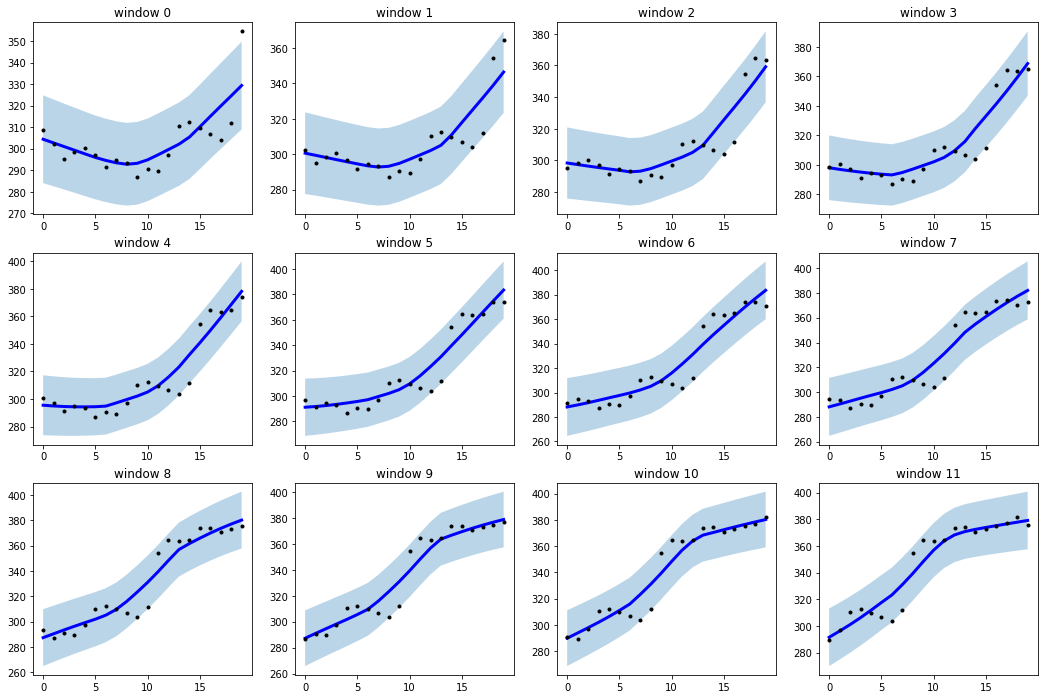

In [62]:
# 绘制前 12 个光滑窗口数据
fig = plt.figure(figsize = (18, 12))
for i, (true_data, smooth_data) in enumerate(zip(true_dataset, smooth_dataset)):
    if i == 12:
        break
    plt.subplot(3, 4, i + 1)
    plt.plot(smooth_data, linewidth = 3, color = "blue")
    plt.plot(true_data, ".k")
    plt.fill_between(range(len(true_data)), low[i], up[i], alpha = 0.3)
    plt.title(f"window {i}")

## Cluster smoothed windows

In [22]:
# scale smoothed windows
smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
print(smooth_scaled.shape)
smooth_scaled

(882, 20, 1)


array([[[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [23]:
smooth_km = TimeSeriesKMeans(
    n_clusters = 4, 
    metric = "dtw", 
    max_iter = 10, 
    random_state = 33
)
smooth_km.fit(smooth_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

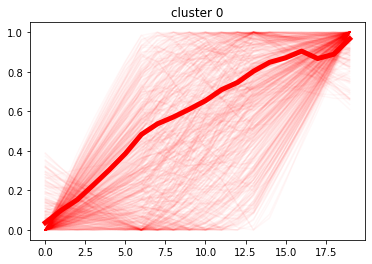

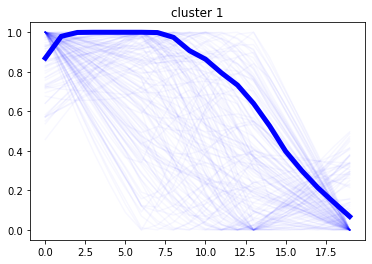

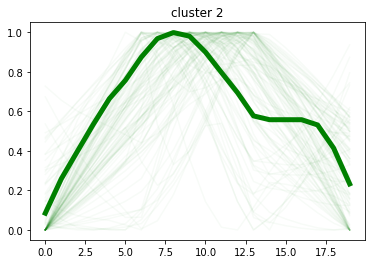

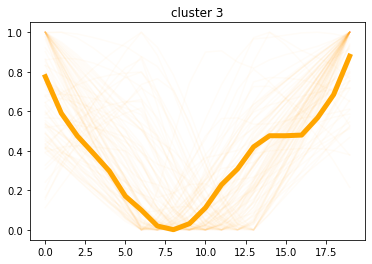

In [24]:
colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
}
for c in range(smooth_km.n_clusters):
    plt.plot(
        np.squeeze(smooth_scaled[smooth_km.labels_ == c], -1).T, 
        c = colors[c], 
        alpha = 0.03
    )
    plt.plot(
        np.squeeze(smooth_km.cluster_centers_, -1)[c],
        c = colors[c],
        linewidth = 5,
    )
    plt.title(f"cluster {c}")
    plt.show()

In [42]:
# smoother.Smoother.data[:, -1]
smoother.Smoother.data

array([[ 309.,  302.,  295., ...,  304.,  312.,  355.],
       [ 302.,  295.,  298., ...,  312.,  355.,  364.],
       [ 295.,  298.,  300., ...,  355.,  364.,  364.],
       ...,
       [1700., 1714., 1694., ..., 1864., 1808., 1817.],
       [1714., 1694., 1700., ..., 1808., 1817., 1779.],
       [1694., 1700., 1711., ..., 1817., 1779., 1777.]])

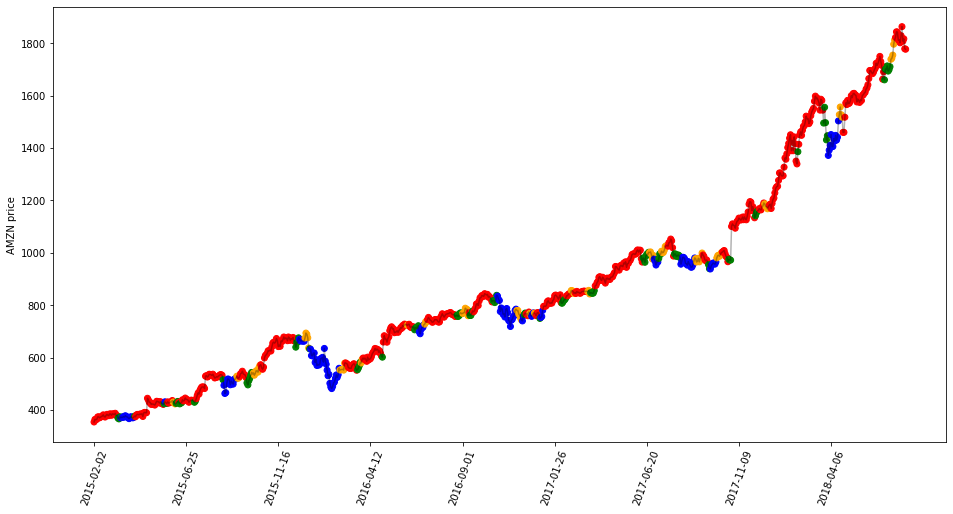

In [25]:
fig = plt.figure(figsize = (16, 8))
plt.plot(
    smoother.Smoother.data[:, -1],
    c = "black",
    alpha = 0.3,
)
plt.scatter(
    range(len(smoother.Smoother.data[:, -1])),
    smoother.Smoother.data[:, -1],
    c = [colors[c] for c in smooth_km.labels_]
)
plt.xticks(
    range(0, len(df.timestamp.unique()) - window_shape, 100), 
    df.timestamp.dt.date.unique()[window_shape::100], 
    rotation = 70
)
plt.ylabel("AMZN price")
np.set_printoptions(False)

## Cluster raw windows

In [26]:
# scale raw windows
raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)
raw_scaled.shape

(882, 20, 1)

In [27]:
# cluster raw windows
raw_km = TimeSeriesKMeans(n_clusters = 4, metric = "dtw", max_iter = 10, random_state = 33)
raw_km.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

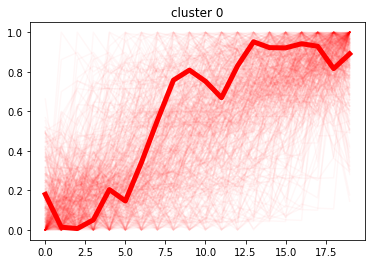

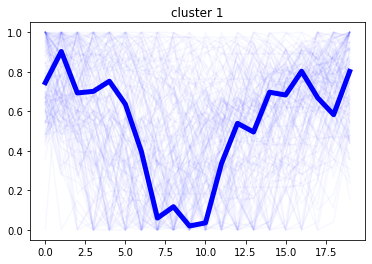

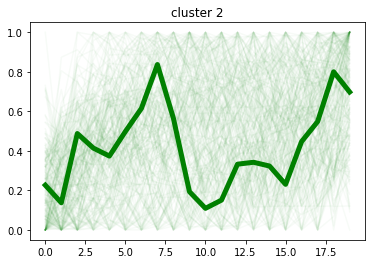

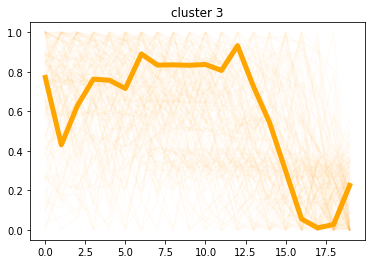

In [28]:
colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
}
for c in range(raw_km.n_clusters):
    plt.plot(
        np.squeeze(raw_scaled[raw_km.labels_ == c], -1).T, 
        c = colors[c], 
        alpha = 0.03
    )
    plt.plot(
        np.squeeze(raw_km.cluster_centers_, -1)[c],
        c = colors[c],
        linewidth = 5,
    )
    plt.title(f"cluster {c}")
    plt.show()

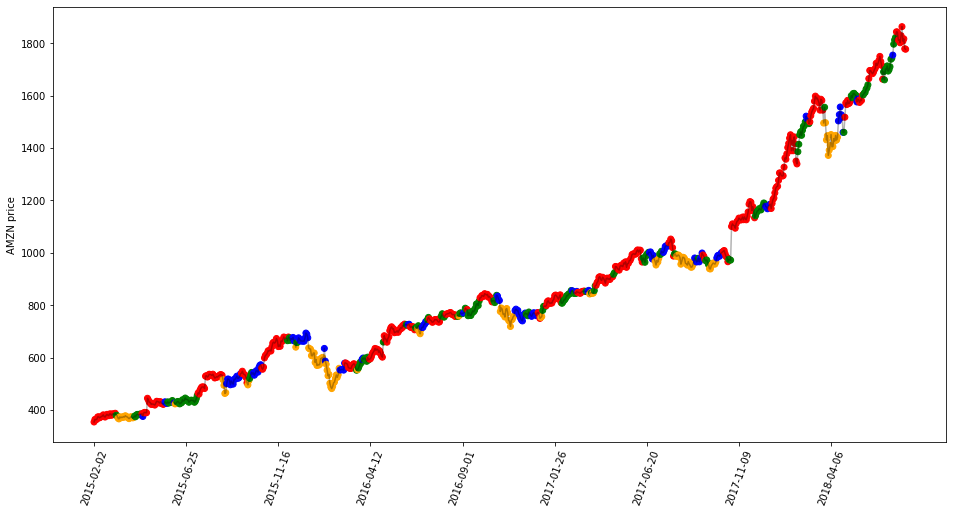

In [40]:
fig = plt.figure(figsize = (16, 8))
plt.plot(
    smoother.Smoother.data[:,-1], 
    c = 'black', 
    alpha = 0.3
)
plt.scatter(
    range(len(smoother.Smoother.data[:,-1])), 
    smoother.Smoother.data[:,-1], 
    c = [colors[c] for c in raw_km.labels_]
)
plt.xticks(
    range(0, len(df.timestamp.unique()) - window_shape, 100), 
    df.timestamp.dt.date.unique()[window_shape::100], 
    rotation = 70
)
plt.ylabel('AMZN price')
np.set_printoptions(False)